High-performance and parallel computing for AI - Practical 6: Stochastic behaviour of rounding errors and stochastic rounding
=============================================================================================================================

IMPORTANT
=========

For these practicals we will be using a different `conda environment`. When opening a notebook or a terminal make sure you are using the **CuPy Kernel**!!!

Question 1 - One last dot product
---------------------------------

Let $a,b\in\mathbb{R}^n$ be defined by either of the following:

* Option 1 - The entries of $a,b$ are i.i.d. uniform random variables in $[0,1]$.
* Option 2 - $a_i = \alpha$, $b_i=\beta$ for all $i$ where $\alpha,\beta$ are independent uniform random variables in $[0,1]$ (i.e., $a,b$ are still random, but have constant entries).

Using fp16 half-precision and round-to-nearest (the default in `chopping`), compute the dot product $a\cdot b$ and its relative rounding error for both options above. Since the vectors are random, take the maximum error across $M=50$ realisations of the inputs. Plot the relative rounding error as a function of $n$ for $n=2^i$, $i=8,\cdots,14$ in loglog scale.

Repeat the experiment using stochastic rounding. How do the errors in round-to-nearest and stochastic rounding grow as a function of $n$?

**Hint:** To activate stochastic rounding, create and use an option with stochastic rounding enabled:
```python
    op = Option(True)
    op.set_format('h') # this is as usual
    op.set_round(5) # 5 for stochastic rounding, 1 for round-to-nearest
```

**Hint:** Here is a useful code portion:

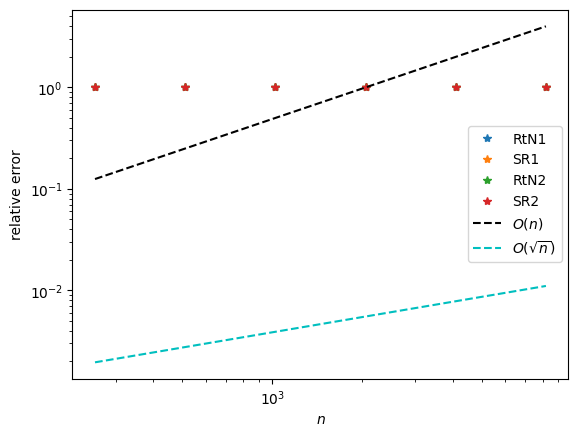

In [1]:
import numpy as np
from chopping import *
import matplotlib.pyplot as plt

op = Option(True)
op.set_format('h')
op.set_round(1)

u = op.get_floating_point_parameters()["u"]

sr = Option(True)
sr.set_format('h')
sr.set_round(5)

def dot(a,b,opt):
    return (LPV(a, opt).T()@LPV(b, opt)).array()[0]

def one_test(n):

    # CHANGE THIS FUNCTION BY USING THE dot FUNCTION ABOVE

    # option 1
    ex1 = 1
    rtn1 = 0
    sr1 = 0

    #option 2
    ex2 = 1
    rtn2 = 0
    sr2 = 0
    
    return [abs(ex1-rtn1)/abs(ex1), abs(ex1-sr1)/abs(ex1), abs(ex2-rtn2)/abs(ex2), abs(ex2-sr2)/abs(ex2)]

def test(n,M):
    return np.max(np.array([one_test(n) for i in range(M)]),axis=0)

NN = 2**np.arange(8,14)
M = 50

errs = np.array([test(n,M) for n in NN])


labels = ["RtN1", "SR1", "RtN2", "SR2"]
for i in range(4):
    plt.loglog(NN, errs[:,i], '*', label=labels[i])

plt.loglog(NN, u*NN, 'k--', label="$O(n)$")
plt.loglog(NN, u*np.sqrt(NN)/4, 'c--', label=r"$O(\sqrt{n})$")

plt.legend()
plt.xlabel("$n$")
plt.ylabel("relative error")
plt.show()

Solution to Question 1
----------------------

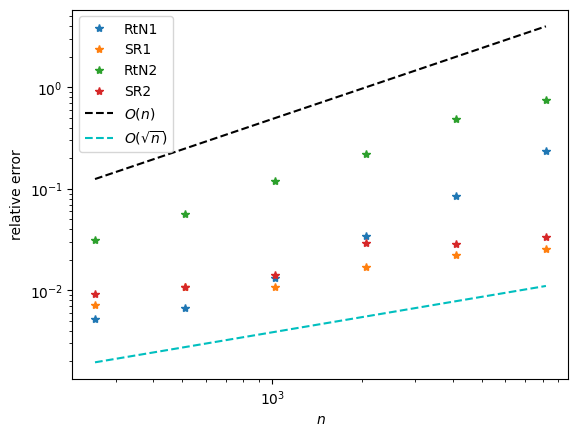

In [2]:
import numpy as np
from chopping import *
import matplotlib.pyplot as plt

op = Option(True)
op.set_format('h')
op.set_round(1)

u = op.get_floating_point_parameters()["u"]

sr = Option(True)
sr.set_format('h')
sr.set_round(5)

def dot(a,b,opt):
    return (LPV(a, opt).T()@LPV(b, opt)).array()[0]

def one_test(n):
    a1 = np.random.rand(n)
    b1 = np.random.rand(n)
    ex1 = a1@b1
    rtn1 = dot(a1,b1,op)
    sr1 = dot(a1,b1,sr)

    alpha = np.random.rand()
    beta = np.random.rand()
    a2 = alpha*np.ones((n,))
    b2 = beta*np.ones((n,))
    ex2 = a2@b2
    rtn2 = dot(a2,b2,op)
    sr2 = dot(a2,b2,sr)

    return [abs(ex1-rtn1)/abs(ex1), abs(ex1-sr1)/abs(ex1), abs(ex2-rtn2)/abs(ex2), abs(ex2-sr2)/abs(ex2)]

def test(n,M):
    return np.max(np.array([one_test(n) for i in range(M)]),axis=0)

NN = 2**np.arange(8,14)
M = 50

errs = np.array([test(n,M) for n in NN])

labels = ["RtN1", "SR1", "RtN2", "SR2"]
for i in range(4):
    plt.loglog(NN, errs[:,i], '*', label=labels[i])

plt.loglog(NN, u*NN, 'k--', label="$O(n)$")
plt.loglog(NN, u*np.sqrt(NN)/4, 'c--', label=r"$O(\sqrt{n})$")

plt.legend()
plt.xlabel("$n$")
plt.ylabel("relative error")
plt.show()    

Question 2
----------

Using fp16 and round-to-nearest, evaluate the truncated harmonic sum

$$ \sum_{n=1}^N \frac{1}{n} $$

for $N=2^{6}$, $N=2^{10}$, $N=2^{14}$. What is the result? What happens if the same value is computed using double precision? What is the exact value of the sum for $N\rightarrow \infty$?

Repeat the above with bf16 and round-to-nearest. What changed? Why?

Repeat using fp16 and stochastic rounding. What changed? Why?

Can you approximately predict at which value of $N$ will stagnation occur for round-to-neareset and fp16?

Hint for the last question: 1) Approximate the sum with $\log(N) + \gamma + \frac{1}{2N}$ where $\gamma$ is the Euler-Mascheroni constant. 2) Under which condition stagnation occurs? You will need to know the roundoff unit of fp16 which is $2^{-11}$. 3) Use `scipy.optimize.root_scalar` to find an approximate $N$ at which stagnation occurs.

Solution to Question 2
----------------------

RtN result:  7.0859375


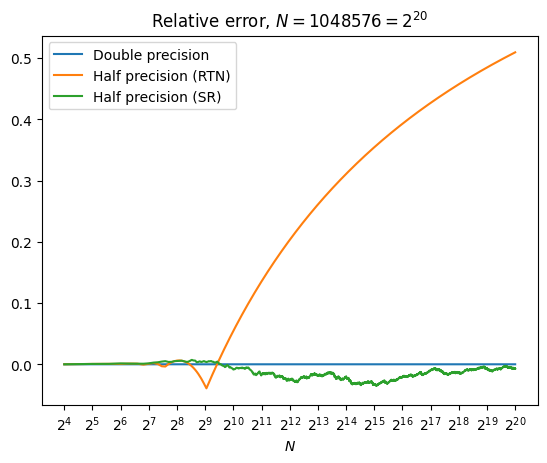

Stagnation will approximately occur at N = 322. The log2 of N is: 8.331


In [3]:
N = 2**20
M = 2**4
NM = int(2**(np.log2(N/M)))

options = Option()

fmt = 'h' # change to 'b' for bfloat16

options.set_format(fmt)
options.set_round(1)

c = lambda x : chop(x,options)

options_sr = Option()
options_sr.set_format(fmt)
options_sr.set_round(5)

sr = lambda x : chop(x,options_sr)

base = 1./np.arange(1,N+1)
base_c = base.copy(); c(base_c)
base_sr = base.copy(); sr(base_sr)
s_double = 0
s_chopped = 0
s_sr = 0
err = np.zeros((NM,3))
eg = np.euler_gamma
for i in range(N):
    s_double = s_double + base[i]
    s_chopped = c(s_chopped + base_c[i])
    s_sr = sr(s_sr + base_sr[i])
    if i%M == 0:
        if i > 20:
            s_ex = np.log(i+1)+eg+1/(2*(i+1))
        else:
            s_ex = s_double

        err[int(i/M), :] = np.array([(s_ex - s_double), (s_ex-s_chopped), (s_ex - s_sr)])/abs(s_ex)

print("RtN result: ", s_chopped)

plt.plot(M*np.arange(1,NM+1),err)
plt.xscale('log', base=2)
plt.xlabel("$N$")
plt.locator_params(axis='x', numticks=20)
plt.legend(('Double precision', 'Half precision (RTN)', 'Half precision (SR)'), loc=2);
plt.title('Relative error, $N = %d = 2^{%d}$' % (N,int(np.log2(N))))
plt.show()


# Stagnation will occur approximately at N given by:
f = lambda n : np.log(n) + eg + 1/(2*n)
u = 2.**-11
g = lambda n : f(n)*u - 1/(n+1)
from scipy.optimize import root_scalar
res = root_scalar(g, x0=100)
N = int(np.ceil(res.root))
print("Stagnation will approximately occur at N = %d. The log2 of N is: %.3f" % (N, np.log2(N)))

Question 3 - Stochastic rounding and gradient descent
-----------------------------------------------------

**Important:** For this exercise you can modify your solution to Question 3 of Practical 5.

Implement the gradient descent method in double precision for minimizing the 2D Rosenbrock function:

$$ f(x,y) = (a-x)^2 + b(y-x^2)^2 $$

where $a=\pi-3$, $b=100$. This function has a unique global minimum at the point $(a, a^2)$. Set the learning rate to $10^{-3}$, the initial condition to zero and the maximum number of iterations to $2 \times 10^4$.

1- Copy and clean up your code from Question 3 of Practical 5 to only keep the pure bfloat16 reduced-precision scheme.

2- Change the `chopping` `Option` rounding mode to stochastic rounding with `op.set_round(5)` and run the code again.

In order to monitor the convergence behaviour of the above, compute the Euclidean norm of the gradient at the current iterate every $100$ iterations. Run both implementations and compare their gradient norms. Can you explain this convergence behaviour based on what we have learnt in the lectures?

Finally, re-run the experiment by setting $a=1/8$. What do you observe? Why do you think this happens?

**Some explanation:** The stochastic rounding evaluation of the gradient here does not have zero-mean error since the gradient is a nonlinear function. However, its bias will be of order $O(u^2)$ (you can try and prove this if you have time, simply Taylor-expand the gradient with respect to the rounding errors and take the expectation). Therefore, gradient descent will have the gradient norm (not its square) converge like $O(1/\sqrt{T})$ until it reaches the RtN bias $O(u)$. For RtN it will stop, while for stochastic rounding it will behave like stochastic gradient descent and will keep converging until it reaches the SR bias $O(u^2)$ when it will stop converging.

Solution to Question 3
----------------------

In [4]:
import numpy as np
from chopping import *

op = Option(True)
op.set_format("b")
op.set_round(1)
u = op.get_floating_point_parameters()["u"] # roundoff unit

# Define rosenbrock function and exact solution
a = np.pi-3
b = 100
rosenbrock = lambda x,y : (a-x)*(a-x) + b*(y - x*x)*(y - x*x)
grad = lambda x,y : [-2*a - 4*b*x*(-x*x + y) + 2*x, b*(-2*x*x + 2*y)]
hess = lambda x,y : [[2*(4*b*x*x + 2*b*(x*x - y) + 1), -4*b*x], [-4*b*x, 2*b]]
ex_sol = np.array([a, a**2])

# libchopping was not really designed for this so we define some utilitiy functions
# to cast to and from LPV objects
no_lpv = lambda z : (z[0].array()[0], z[1].array()[0]) if isinstance(z[0], LPV) else z
to_lpv = lambda z,op=op : (LPV(np.array([z[0]]), op), LPV(np.array([z[1]]), op)) if not isinstance(z[0], LPV) else z

def gd(z, op, gamma = 1.0e-3):
    z = to_lpv(z,op) # updates are performed in reduced precision
    update = grad(*z) # reduced-precision gradient
    return no_lpv([z[0] - gamma*update[0], z[1] - gamma*update[1]])

maxits = 20000
gamma = 1.0e-3

z = np.zeros((2,2))
gnorms = np.zeros((2,))

print("\n\nGRADIENT DESCENT:\n")
for i in range(1,maxits+1):
    for j in range(2):
        op.set_round(1 if j == 0 else 5)
        z[j] = gd(z[j], op, gamma=gamma)
        gnorms[j] = np.linalg.norm(grad(*z[j]))
        
    if i%1000 == 0:
        print("Iteration %5d:" % i, " Gradient norm RtN: %e" % gnorms[0], " Gradient norm SR: %e" % gnorms[1])

distances = tuple([np.linalg.norm(np.array(item) - ex_sol) for item in z])
print("\nDistance from global minima.\t RtN: %e\t SR: %e" % distances)

# If you set a = 1/8 the global optimum becomes exactly representable in bfloat16 half precision so GD will be able to converge to it.
# This shows that what GD does once it reaches a neighbourhood of the optimum with stochastic rounding is to start "hopping around" a
# neighbourhood of the optimum trying to get there. Unfortunately in general it won't be able to converge there since it is not representable.



GRADIENT DESCENT:

Iteration  1000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 4.207647e-02
Iteration  2000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.935307e-03
Iteration  3000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.882759e-02
Iteration  4000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.415494e-02
Iteration  5000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 5.132711e-03
Iteration  6000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.935307e-03
Iteration  7000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 6.546672e-03
Iteration  8000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.935307e-03
Iteration  9000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.935307e-03
Iteration 10000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 6.546672e-03
Iteration 11000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 6.546672e-03
Iteration 12000:  Gradient norm RtN: 1.575406e-01  Gradient norm SR: 1.415494